In [2]:
import os
import datetime
import numpy as np
import math
import pandas as pd
import time
import warnings
import glob
from scipy.stats import ttest_ind, chisquare
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import getpass
import pickle
# import treelite
import zipfile
from collections import Counter
import shutil
from scipy.stats import pearsonr, spearmanr
import json
import re
from sqlalchemy import create_engine
from math import cos, asin, sqrt
from collections import OrderedDict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pprint import pprint
import lightgbm as lgb
import configparser
import os
import pickle
import sys
from collections import OrderedDict
from pprint import pprint
# from h3 import h3
from time import time
import pyodbc
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import Image, display,HTML
from sklearn.linear_model import LinearRegression

pd.set_option("display.max_columns", 90)
pd.set_option("display.max_rows", 300)
# pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 999)


/Users/elizavetalebedeva/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('data/workplace.csv')

# Workplace

In [3]:
df.head()

,time,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,...,right_shoulder_y,right_shoulder_z,right_elbow_x,right_elbow_y,right_elbow_z,right_wrist_x,right_wrist_y,right_wrist_z,good_posture,moving
0,2019-10-16 11:09:54.815697432,-24,-25,-24,-25,-24,-25,-25,-25,-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,2019-10-16 11:09:54.820406437,-25,-25,-24,-24,-25,-24,-24,-25,-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2,2019-10-16 11:09:54.825275183,-24,-25,-25,-25,-24,-25,-24,-24,-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
3,2019-10-16 11:09:54.830595493,-25,-24,-24,-24,-24,-25,-24,-24,-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
4,2019-10-16 11:09:54.835609674,-24,-25,-24,-25,-25,-25,-23,-23,-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [18]:
# Additionally you can transform the data into phase and amplitude data with
# these functions.
def calculate_phase(raw_data, bin=2):
    """Calculate phase from raw radar data sample.
       Phase information tells about
       target micromovements"""
    s = np.array(raw_data)
    S = np.fft.fft(s)
    ph = np.angle(S)
    phase = ph[bin]
    return phase


def calculate_phases(raw_data, start=1, end=6):
    """Calculate phases from raw radar data sample
       and return multiple bins. Phase information tells about
       target micromovements"""
    s = np.array(raw_data)
    S = np.fft.fft(s)
    ph = np.angle(S)
    return ph[start:end]

def calculate_amplitude(raw_data, bin=2):
    """Calculate amplitude from raw radar data sample.
       Amplitude depends on the target size."""
    s = np.array(raw_data)
    S = np.fft.fft(s)
    amplitude = np.abs(S)
    return amplitude

In [39]:
df_clean = df.dropna().copy()
amplitude = calculate_amplitude(df_clean.iloc[:,1:])
phase = calculate_phase(df_clean.iloc[:,1:])
amplitude, phase

(array([[11079.908418  , 26291.28129122, 26496.04075627, ...,
          4636.2316009 , 26496.04075627, 26291.28129122],
        [14366.710048  , 11468.48706454,  1500.95043327, ...,
          1722.55539222,  1500.95043327, 11468.48706454],
        [10861.70827   , 22316.16407601, 19012.61678983, ...,
          3222.69327781, 19012.61678983, 22316.16407601],
        ...,
        [  939.788975  , 47356.28361081, 34424.63131029, ...,
         11404.37971142, 34424.63131029, 47356.28361081],
        [ 6065.87145   , 48253.03214178, 29408.99828601, ...,
          7074.72464284, 29408.99828601, 48253.03214178],
        [31144.802461  , 37771.34072754, 43407.27934171, ...,
         10281.20777769, 43407.27934171, 37771.34072754]]),
 array([ 3.14159265,  1.36877203, -1.5966285 , -1.3098455 ,  2.85682798,
        -2.47755466,  1.35942173,  1.31219847,  1.32015192,  1.43567418,
         1.24531983,  1.78943605,  2.29153952,  2.56517427,  2.93259937,
        -3.0552987 , -2.50963253, -2.07405876,

In [25]:
df.dropna()

,time,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,...,right_shoulder_y,right_shoulder_z,right_elbow_x,right_elbow_y,right_elbow_z,right_wrist_x,right_wrist_y,right_wrist_z,good_posture,moving
6762,2019-10-16 11:10:28.627168655,-25,-24,-25,-24,-24,-25,-24,-23,-23,...,-0.006384,0.159608,0.059726,0.035223,0.153143,0.000000,0.000000,0.000000,1.0,0.0
7163,2019-10-16 11:10:30.632459641,-25,-25,-23,-24,-25,-24,-23,-25,-24,...,-0.010176,0.254398,0.094275,0.055598,0.241731,0.000000,0.000000,0.000000,1.0,0.0
7562,2019-10-16 11:10:32.627892494,-24,-24,-25,-25,-25,-24,-24,-24,-24,...,-0.007548,0.251586,0.094408,0.055677,0.242072,0.000000,0.000000,0.000000,1.0,0.0
8163,2019-10-16 11:10:35.632594824,-24,-24,-23,-25,-24,-25,-25,-24,-23,...,-0.010130,0.253249,0.095205,0.058588,0.244117,0.000000,0.000000,0.000000,1.0,0.0
8563,2019-10-16 11:10:37.632996798,-25,-25,-24,-24,-24,-24,-24,-24,-24,...,-0.005036,0.167880,0.062726,0.036992,0.160836,0.000000,0.000000,0.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214747,2019-10-16 11:27:48.633105040,-24,-25,-24,-25,-25,-25,-25,-25,-26,...,0.004930,0.246484,0.094712,0.051195,0.255977,0.073544,0.077046,0.175105,0.0,1.0
215547,2019-10-16 11:27:52.633435011,-24,-24,-25,-25,-24,-25,-25,-25,-25,...,0.006063,0.202103,0.081440,0.054293,0.208820,0.061411,0.065695,0.142815,0.0,1.0
216147,2019-10-16 11:27:55.633881330,-24,-24,-24,-24,-24,-25,-24,-24,-23,...,0.007274,0.242456,0.098389,0.068116,0.252281,0.074842,0.074842,0.166316,0.0,1.0
216547,2019-10-16 11:27:57.633728504,-24,-24,-25,-24,-24,-25,-24,-24,-24,...,0.004829,0.241440,0.093987,0.053344,0.254018,0.074256,0.074256,0.168763,0.0,1.0


In [3]:
# decided proceed wth meeting room data set

# Meeting room

In [4]:
# read one file
data_folder = "data/office_full/"
office_data = np.loadtxt(data_folder + 'amplitude/amplitude01',delimiter=',')
office_data = np.reshape(office_data,(office_data.shape[0],180,110))

In [52]:
# read many
data_folder = "data/office_full/"
# office_data = np.zeros(shape=(1, 19800))
# filelist = glob.glob(os.path.join(data_folder+'amp2/','amplitude*'))
# for file in filelist:
#     office_data_tmp = np.loadtxt(file,delimiter=',')
#     office_data = np.append(office_data, office_data_tmp, axis=0)

office_data = np.reshape(office_data,(office_data.shape[0],180,110))
office_data.shape

(8401, 180, 110)

In [51]:
office_data.shape

(8401, 19800)

In [74]:
# save reshaped data
# np.savetxt('amp_full', np.reshape(office_data,(office_data.shape[0],180*110)))
# np.loadtxt('amp_full',delimiter='')

In [75]:
# np.append(office_data, office_data, axis=0).shape

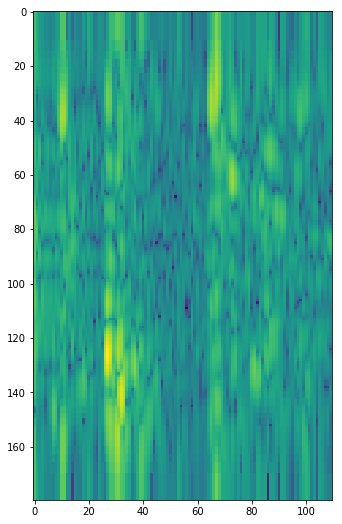

In [5]:
plt.figure(figsize = (8,9))
plt.imshow(office_data[150, :, :])
plt.show()

In [6]:
bounding = json.loads(open('data/office_full/bounding.json').read())

In [7]:
display(bounding[0])
len(bounding)

{'category_id': 0,
 'id': 0,
 'area': 183411,
 'image_id': 0,
 'bbox': [835.9, 277.8, 1267.6, 702.7]}

100430

In [8]:
df_bounding = pd.DataFrame(bounding)

In [9]:
df_bounding.describe()

,category_id,id,area,image_id
count,100430.0,100430.000000,100430.000000,100430.000000
mean,0.0,50214.500000,28129.167579,13273.793329
std,0.0,28991.788105,31596.420458,5810.737752
min,0.0,0.000000,589.000000,0.000000
25%,0.0,25107.250000,6511.000000,8878.250000
50%,0.0,50214.500000,17014.000000,13196.500000
75%,0.0,75321.750000,39769.750000,17327.000000
max,0.0,100429.000000,569188.000000,23807.000000


In [10]:
df_bounding['x'] = df_bounding.bbox.apply(lambda x: x[0])
df_bounding['y'] = df_bounding.bbox.apply(lambda x: x[1])
df_bounding['x1'] = df_bounding.bbox.apply(lambda x: x[2])
df_bounding['y1'] = df_bounding.bbox.apply(lambda x: x[3])


df_bounding['x_n'] = df_bounding.x/1280*110
df_bounding['y_n'] = df_bounding.y/720*180
df_bounding['x1_n'] = df_bounding.x1/1280*110
df_bounding['y1_n'] = df_bounding.y1/720*180

df_bounding.head()

,category_id,id,area,image_id,bbox,x,y,x1,y1,x_n,y_n,x1_n,y1_n
0,0,0,183411,0,"[835.9, 277.8, 1267.6, 702.7]",835.9,277.8,1267.6,702.7,71.835156,69.450,108.934375,175.675
1,0,1,183188,1,"[836.5, 280.4, 1267.8, 705.2]",836.5,280.4,1267.8,705.2,71.886719,70.100,108.951562,176.300
2,0,2,186000,2,"[834.4, 279.2, 1274.0, 702.3]",834.4,279.2,1274.0,702.3,71.706250,69.800,109.484375,175.575
3,0,3,187106,3,"[835.6, 283.5, 1280.0, 704.6]",835.6,283.5,1280.0,704.6,71.809375,70.875,110.000000,176.150
4,0,4,187576,4,"[827.3, 276.3, 1268.2, 701.8]",827.3,276.3,1268.2,701.8,71.096094,69.075,108.985938,175.450


In [11]:
np.array(df_bounding.bbox[10])-np.array(df_bounding.bbox[0])

array([ 11.8, -28.8,  12.4,   3.8])

In [12]:
office_data.shape

(600, 180, 110)

In [13]:
b_box = df_bounding.loc[0,['x_n', 'y_n', 'x1_n', 'y1_n']]
b_box

x_n     71.8352
y_n       69.45
x1_n    108.934
y1_n    175.675
Name: 0, dtype: object

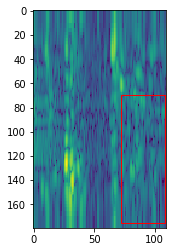

In [73]:
office_data_r = np.reshape(office_data,(office_data.shape[0],180,110))
import matplotlib.patches as patches
fig,ax = plt.subplots(1)
# plt.figure(figsize = (8,9))
plt.imshow(office_data_r[1, :, :])
rect = patches.Rectangle((b_box[0],b_box[1]),b_box[2]-b_box[0],b_box[3]-b_box[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)


plt.show()

In [74]:
(b_box[0],b_box[1]),b_box[2]-b_box[0],b_box[3]-b_box[1]

((71.83515625, 69.45), 37.09921874999999, 106.22500000000001)

In [15]:
pd.DataFrame(office_data[2, :, :]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,...,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,103.205977,96.878779,92.806685,92.315270,89.701488,90.343390,89.427522,92.766353,91.193934,88.781433,95.526078,98.973988,96.602421,91.774558,95.178280,92.166786,87.738155,89.303500,91.430404,89.736285,91.110426,89.734547,84.478056,85.129266,85.650312,88.577913,95.951327,104.671894,106.409473,99.943670,99.709904,104.631456,104.849679,100.938060,96.045604,94.770555,88.988089,92.757881,92.314338,95.901148,93.861775,90.445832,92.423344,89.957120,83.901350,...,99.999039,101.283952,105.419920,102.163916,97.643797,91.998568,92.484167,95.180072,97.046546,91.628650,92.059197,91.216054,87.855272,91.305617,89.482782,89.916156,90.800691,91.397362,93.076109,91.300311,95.168942,94.598479,93.490074,92.451971,94.634835,91.704202,92.606403,89.673553,83.117311,86.179515,86.684760,89.102389,90.078102,92.211535,91.628672,92.793268,91.858472,86.833408,88.287385,82.766544,89.881991,89.265466,88.332761,86.473891,86.309657
std,4.242818,5.575435,5.007379,4.319342,6.419219,5.053455,5.313096,7.062176,5.769983,6.870786,6.617502,5.989176,7.900764,7.234336,4.441550,5.520853,6.046661,5.709768,7.249507,4.565534,6.230073,5.344864,5.684196,4.876493,6.656503,4.093728,10.612659,9.765138,7.255983,7.943979,10.346464,10.015138,8.690072,8.729553,7.601139,5.651878,7.776788,8.737197,7.719993,7.606913,8.103204,7.539243,6.293432,6.737158,6.647640,...,7.356716,6.828452,7.851749,7.341607,4.496720,6.121144,5.687636,6.803395,7.777544,8.966482,4.187798,5.331554,6.675427,3.196865,4.269529,6.810802,8.325655,6.450441,7.285415,6.663056,5.727665,6.199403,7.788591,7.168406,4.609668,5.082231,5.055253,6.178915,6.552146,5.918712,3.915216,5.782994,6.503651,5.995238,7.380942,6.843873,5.579074,4.924279,5.078133,8.772924,5.899351,4.350262,7.313383,4.589617,6.095048
min,81.406160,78.911520,75.504850,75.836210,68.292440,75.002660,75.529120,65.852860,73.147660,72.046660,77.251640,81.879180,73.072570,66.765240,69.337900,76.693210,76.685580,76.535570,63.437460,72.066080,53.313820,72.863480,61.893050,72.172060,58.858600,67.891100,63.590470,80.987030,82.594130,72.222890,73.434930,83.541230,75.344980,71.523170,72.225890,78.757670,74.142630,72.864460,66.681720,66.414370,71.649260,64.497780,80.094510,71.247160,66.816390,...,85.799330,83.492600,75.526210,73.779980,85.310070,71.009720,72.925680,73.659800,70.848150,72.203310,66.724710,73.328050,67.179820,80.968850,74.091540,71.531300,66.249410,74.170500,69.624610,73.939740,79.526720,81.594400,70.130960,75.139060,81.313520,80.390180,77.697010,72.909120,64.769190,64.290030,76.008380,69.132600,72.323990,70.765270,67.243600,74.332230,72.582700,62.827880,62.724760,60.199720,66.100000,78.752840,46.593850,71.298860,63.139770
25%,101.245790,93.733708,89.304185,90.583260,85.453945,86.064590,85.665678,87.

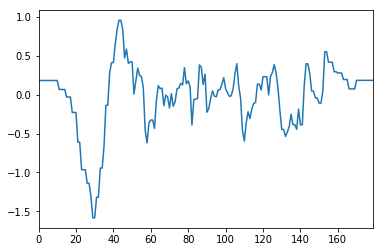

In [16]:
pd.DataFrame(office_data[2, :, :]-office_data[0, :, :]).T.mean().plot()

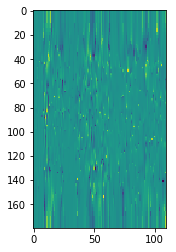

In [17]:
# movie in 15fps, radar data 100 fps
plt.imshow(office_data[2, :, :]-office_data[0, :, :])

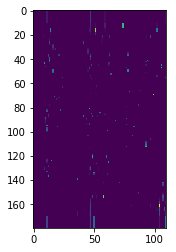

In [18]:
plt.imshow(np.clip(abs(office_data[1, :, :]-office_data[0, :, :]), a_min=10, a_max=None))

In [19]:
sum(abs(office_data[5, :, :]-office_data[0, :, :])>0.5).sum()/(office_data.shape[0]*office_data.shape[1]*office_data.shape[2])

0.0011752525252525252

In [20]:
# Align frames
# take averages from every 6 fps from radar

def return_15_fps(frames):
    i=0
    averages = np.zeros(shape=(1, 19800))
    for batch in range(1,frames.shape[0]+1):
        if batch % 100 == 0:
            i_rows =i*100
#             print(i_rows, batch)
            office_data_tmp = frames[i_rows:batch, :]
            df = pd.DataFrame(office_data_tmp).rolling(6).mean() 
            df = df.iloc[::6, :]
    #         display(df)
            averages = np.append(averages, df.iloc[1:16,:].to_numpy(), axis=0)
            i+=1
#             print(averages.shape)
    return(averages[1:,:])


In [21]:
# read one
data_folder = "data/office_full/"
office_data = np.loadtxt(data_folder + 'amplitude/amplitude01',delimiter=',')
# office_data = np.reshape(office_data,(office_data.shape[0],180,110))

In [22]:
# read many
data_folder = "data/office_full/"
office_data = np.zeros(shape=(1, 19800))
# sorted(glob.glob(os.path.join(data_folder+'amp2/','amplitude*')))
filelist = sorted(glob.glob(os.path.join(data_folder+'amp2/','amplitude*')))
for file in filelist:
    print(file)
    office_data_tmp = np.loadtxt(file,delimiter=',')
    averages_from_file = return_15_fps(office_data_tmp)
    office_data = np.append(office_data, averages_from_file, axis=0)
    print(office_data.shape)
# office_data = np.reshape(office_data,(office_data.shape[0],180,110))
office_data.shape

data/office_full/amp2/amplitude01
(91, 19800)
data/office_full/amp2/amplitude02
(181, 19800)
data/office_full/amp2/amplitude03
(271, 19800)
data/office_full/amp2/amplitude04
(361, 19800)
data/office_full/amp2/amplitude05
(451, 19800)
data/office_full/amp2/amplitude06
(541, 19800)
data/office_full/amp2/amplitude07
(631, 19800)
data/office_full/amp2/amplitude08
(721, 19800)
data/office_full/amp2/amplitude09
(811, 19800)
data/office_full/amp2/amplitude10
(901, 19800)
data/office_full/amp2/amplitude11
(991, 19800)
data/office_full/amp2/amplitude12
(1081, 19800)
data/office_full/amp2/amplitude13
(1171, 19800)
data/office_full/amp2/amplitude14
(1261, 19800)
data/office_full/amp2/amplitude15
(1351, 19800)
data/office_full/amp2/amplitude16
(1441, 19800)
data/office_full/amp2/amplitude17
(1531, 19800)
data/office_full/amp2/amplitude18
(1621, 19800)
data/office_full/amp2/amplitude19
(1711, 19800)
data/office_full/amp2/amplitude20
(1801, 19800)
data/office_full/amp2/amplitude21
(1891, 19800)
data

(2701, 19800)

In [ ]:
# easy approach: each 20th, every 3d

In [24]:
# office_data = office_data[1:,:]
office_data.shape

(2701, 19800)

# Merge boxes and apmlitudes

In [25]:
df_bounding
# office_data_flipped = np.flip(np.transpose(office_data))
# office_data_flipped

,category_id,id,area,image_id,bbox,x,y,x1,y1,x_n,y_n,x1_n,y1_n
0,0,0,183411,0,"[835.9, 277.8, 1267.6, 702.7]",835.9,277.8,1267.6,702.7,71.835156,69.450,108.934375,175.675
1,0,1,183188,1,"[836.5, 280.4, 1267.8, 705.2]",836.5,280.4,1267.8,705.2,71.886719,70.100,108.951562,176.300
2,0,2,186000,2,"[834.4, 279.2, 1274.0, 702.3]",834.4,279.2,1274.0,702.3,71.706250,69.800,109.484375,175.575
3,0,3,187106,3,"[835.6, 283.5, 1280.0, 704.6]",835.6,283.5,1280.0,704.6,71.809375,70.875,110.000000,176.150
4,0,4,187576,4,"[827.3, 276.3, 1268.2, 701.8]",827.3,276.3,1268.2,701.8,71.096094,69.075,108.985938,175.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100425,0,100425,6233,23806,"[411.5, 263.1, 469.5, 370.5]",411.5,263.1,469.5,370.5,35.363281,65.775,40.347656,92.625
100426,0,100426,41515,23807,"[192.7, 315.2, 384.1, 532.2]",192.7,315.2,384.1,532.2,16.560156,78.800,33.008594,133.050
100427,0,100427,12492,23807,"[747.0, 327.3, 847.0, 452.2]",747.0,327.3,847.0,452.2,64.195312,81.825,72.789062,113.050
100428,0,100428,9671,23807,"[536.8, 310.1, 632.3, 411.4]",536.8,310.1,632.3,411.4,46.131250,77.525,54.338281,102.850


In [26]:
df_bounding.head()

,category_id,id,area,image_id,bbox,x,y,x1,y1,x_n,y_n,x1_n,y1_n
0,0,0,183411,0,"[835.9, 277.8, 1267.6, 702.7]",835.9,277.8,1267.6,702.7,71.835156,69.450,108.934375,175.675
1,0,1,183188,1,"[836.5, 280.4, 1267.8, 705.2]",836.5,280.4,1267.8,705.2,71.886719,70.100,108.951562,176.300
2,0,2,186000,2,"[834.4, 279.2, 1274.0, 702.3]",834.4,279.2,1274.0,702.3,71.706250,69.800,109.484375,175.575
3,0,3,187106,3,"[835.6, 283.5, 1280.0, 704.6]",835.6,283.5,1280.0,704.6,71.809375,70.875,110.000000,176.150
4,0,4,187576,4,"[827.3, 276.3, 1268.2, 701.8]",827.3,276.3,1268.2,701.8,71.096094,69.075,108.985938,175.450


In [27]:
df_bounding.drop_duplicates(subset=['image_id'])

,category_id,id,area,image_id,bbox,x,y,x1,y1,x_n,y_n,x1_n,y1_n
0,0,0,183411,0,"[835.9, 277.8, 1267.6, 702.7]",835.9,277.8,1267.6,702.7,71.835156,69.450,108.934375,175.675
1,0,1,183188,1,"[836.5, 280.4, 1267.8, 705.2]",836.5,280.4,1267.8,705.2,71.886719,70.100,108.951562,176.300
2,0,2,186000,2,"[834.4, 279.2, 1274.0, 702.3]",834.4,279.2,1274.0,702.3,71.706250,69.800,109.484375,175.575
3,0,3,187106,3,"[835.6, 283.5, 1280.0, 704.6]",835.6,283.5,1280.0,704.6,71.809375,70.875,110.000000,176.150
4,0,4,187576,4,"[827.3, 276.3, 1268.2, 701.8]",827.3,276.3,1268.2,701.8,71.096094,69.075,108.985938,175.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100410,0,100410,40952,23803,"[192.1, 316.0, 384.7, 528.6]",192.1,316.0,384.7,528.6,16.508594,79.000,33.060156,132.150
100414,0,100414,39494,23804,"[193.1, 315.7, 383.2, 523.4]",193.1,315.7,383.2,523.4,16.594531,78.925,32.931250,130.850
100418,0,100418,42941,23805,"[191.2, 315.7, 385.7, 536.5]",191.2,315.7,385.7,536.5,16.431250,78.925,33.146094,134.125
100422,0,100422,42730,23806,"[192.2, 314.5, 385.3, 535.8]",192.2,314.5,385.3,535.8,16.517187,78.625,33.111719,133.950


In [28]:
pd.DataFrame(df_bounding.image_id.unique(), columns=['image_id'])

,image_id
0,0
1,1
2,2
3,3
4,4
...,...
22644,23803
22645,23804
22646,23805
22647,23806


In [29]:
df_office = pd.DataFrame(office_data)
df_office.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,...,19755,19756,19757,19758,19759,19760,19761,19762,19763,19764,19765,19766,19767,19768,19769,19770,19771,19772,19773,19774,19775,19776,19777,19778,19779,19780,19781,19782,19783,19784,19785,19786,19787,19788,19789,19790,19791,19792,19793,19794,19795,19796,19797,19798,19799
2696,103.683502,99.558220,91.920097,90.180305,87.431987,86.280023,84.643435,87.779050,88.611252,84.543712,82.143130,83.961248,80.809990,84.801872,75.384855,88.619967,78.769080,82.165323,91.472670,88.236485,97.063730,93.016288,81.347475,84.496635,93.280213,87.584583,86.751083,94.613412,103.727862,102.811770,107.717153,108.449535,105.843630,104.704722,90.608583,94.677593,84.967222,88.114492,97.471972,104.889082,103.595872,96.131205,93.056682,88.516097,87.244955,...,94.505812,102.897353,110.328935,104.171327,93.982053,93.464955,93.651475,92.213877,84.454813,90.589580,93.231760,79.666587,92.544610,89.971583,92.465397,89.315925,85.523975,95.352687,95.030938,93.769405,96.009300,87.459653,96.989833,94.921250,86.254268,93.222175,98.558432,94.903755,85.647357,81.529627,80.963105,78.328592,87.119692,91.673868,96.154000,99.701760,97.814882,81.886160,88.421350,76.737885,93.425135,94.172322,91.914988,85.105890,88.277355
2697,103.598815,99.345335,92.331730,89.974700,87.316663,86.349553,84.839458,88.077745,88.670072,84.576872,81.497812,83.793680,81.302300,84.190400,77.890183,88.059663,77.858968,82.015865,91.548945,87.966987,96.837970,92.843858,80.500193,84.544958,93.340435,87.503920,86.548427,94.638745,103.618320,102.754185,107.742652,108.466515,105.810768,104.614725,90.393088,94.786070,85.013295,87.490848,97.331873,104.883365,103.592042,96.132955,92.994290,87.864732,86.605965,...,94.747097,102.840755,110.312753,104.255307,94.042190,93.382552,93.684522,92.127013,84.289847,90.451405,93.192505,80.849745,92.670003,90.028077,92.588735,89.215668,84.820598,95.477740,94.730898,93.928283,96.011277,87.107040,96.986472,95.144230,86.612047,92.875490,98.802067,96.116978,74.796962,76.697615,82.170148,80.354225,86.177647,92.011062,96.473752,100.207453,98.771278,84.243747,87.569998,78.406900,92.865180,93.812537,91.849197,83.162100,87.421005
2698,103.637590,99.483922,91.989503,90.390405,87.381563,85.953023,84.958992,87.850075,88.544488,84.791037,81.623683,83.942978,80.482500,85.051422,76.111953,88.397545,78.732357,81.927312,91.595628,88.210717,97.119180,93.153657,81.405038,85.016548,93.233980,87.614557,86.189788,94.564918,103.630798,102.794077,107.783498,108.495567,105.771752,104.521307,90.444873,94.810527,85.037473,87.680425,97.330555,104.839007,103.532238,96.002395,93.010108,88.286267,87.213592,...,94.626088,102.881248,110.330942,104.195565,93.889848,93.393278,93.848737,92.220083,84.327477,90.542025,93.504857,79.548572,92.656412,90.100697,92.399128,88.702550,84.649632,95.381233,95.068005,93.703528,95.834907,86.769465,96.922935,95.145715,86.863393,92.810520,98.751557,96.774220,74.715323,80.659598,83.766545,82.493438,86.915272,92.783382,96.584117,100.523847,98.978697,80.695717,86.022095,80.790790,93.761238,94.692767,91.880092,81.983380,86.746260
2699,103.657330,99.553840,91.911673,90.504048,87.040205,86.438018,84.984957,87.649292,88.658918,84.584322,81.491920,84.421397,80.511690,84.617255,76.444083,88.325745,78.511968,82.259218,91.354018,87.878855,97.065478,92.918602,80.398617,84.633490,93.264432,87.540257,86.314167,94.490947,103.647923,102.833068,107.806395,108.451492,105.782312,104.505653,90.238908,94.750240,84.435625,87.280173,97.337898,104.825183,103.506520,95.928303,93.035283,88.011517,86.651855,...,94.656010,102.612055,110.212847,104.165360,93.900422,93.348727,93.518548,91.971525,84.302338,90.553730,93.233422,80.044188,92.515705,89.855055,92.411072,88.979322,84.905588,95.420378,94.799582,93.824270,96.053028,87.041447,96.940077,95.152262,86.787903,92.877402,98.705388,96.004565,85.930070,85.473177,84.425367,81.916918,89.299703,93.440520,96.119837,99.596338,97.3

In [30]:
df_office['image_id'] = df_office.index.values

In [31]:
df_merged = df_office.merge(df_bounding.drop_duplicates(subset=['image_id']), on='image_id', how='left')
df_merged.shape


(2701, 19813)

In [32]:
df_merged = df_merged.dropna()
df_merged.shape

(1695, 19813)

In [33]:
df_merged.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,...,19768,19769,19770,19771,19772,19773,19774,19775,19776,19777,19778,19779,19780,19781,19782,19783,19784,19785,19786,19787,19788,19789,19790,19791,19792,19793,19794,19795,19796,19797,19798,19799,image_id,category_id,id,area,bbox,x,y,x1,y1,x_n,y_n,x1_n,y1_n
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,183411.0,"[835.9, 277.8, 1267.6, 702.7]",835.9,277.8,1267.6,702.7,71.835156,69.450,108.934375,175.675
1,103.890688,99.389493,92.292785,90.652115,86.637347,86.394877,84.231265,87.884398,87.725142,89.026590,93.252740,104.079848,104.180353,94.341388,87.995153,88.443205,80.221325,83.617942,91.720410,88.999465,97.043128,92.853248,82.399138,84.778720,92.015867,86.153788,86.117767,95.272590,103.823858,103.084658,108.023237,108.492792,105.230655,104.058323,90.419800,94.582208,83.459978,83.632225,96.345357,104.623165,103.480377,95.228600,95.321928,91.877700,82.380847,...,90.162020,90.719625,86.194412,88.361760,95.222330,93.805820,92.770828,94.535600,76.719052,91.796643,93.833225,90.382018,77.005330,92.555177,91.835667,85.637742,82.741542,80.556357,83.858325,83.779528,92.146045,97.045930,99.803418,97.249917,81.978492,90.666242,73.855540,92.695082,91.567113,88.599228,83.503612,79.776173,1,0.0,1.0,183188.0,"[836.5, 280.4, 1267.8, 705.2]",836.5,280.4,1267.8,705.2,71.886719,70.100,108.951562,176.300
2,103.819012,99.393425,92.351613,90.403083,86.693100,86.753613,84.832700,87.554260,88.996125,85.833288,95.889557,104.104660,102.152297,91.528283,94.957740,93.065477,83.969208,83.121020,91.732235,88.127532,96.978577,92.950802,81.908707,84.349640,92.291957,88.220723,87.335027,94.765385,103.891893,103.222850,107.894962,108.516153,105.494042,104.270250,91.542025,94.797488,85.731137,86.637197,97.182043,105.176363,103.807973,95.662883,91.620473,87.698675,87.435330,...,91.450200,91.934323,86.516157,87.770790,94.492767,93.908312,93.222865,95.183810,78.639553,92.940815,93.998618,88.565733,81.118540,95.210227,94.110568,85.555580,84.161833,78.378923,80.795487,82.452995,90.503747,96.229327,100.324357,98.122925,80.548220,88.984638,76.080603,92.811925,91.696585,88.419025,74.788497,75.336137,2,0.0,2.0,186000.0,"[834.4, 279.2, 1274.0, 702.3]",834.4,279.2,1274.0,702.3,71.706250,69.800,109.484375,175.575
3,103.839885,99.376922,92.144760,90.749768,86.718913,86.284722,84.630773,87.434267,89.314557,88.823073,100.370120,108.163990,106.551148,98.490737,90.023890,91.163808,82.762022,79.759283,91.729235,88.839508,97.518465,92.570983,82.393833,85.784577,93.276250,88.212758,86.596353,94.228260,103.759808,103.121803,107.827275,108.527445,105.353452,104.057037,90.586780,94.900665,84.579930,86.346182,97.091438,105.031987,103.851773,96.027073,93.348107,88.109323,87.433053,...,91.624622,91.810502,85.948933,87.653555,94.536718,94.110908,94.162158,95.357480,84.889585,90.761827,93.250682,88.803555,78.740953,93.607323,92.451502,86.871913,83.426565,79.208725,81.465838,85.221032,91.501957,96.103755,99.290402,96.659247,80.313177,89.389052,76.801080,92.457007,91.676512,90.550523,82.744277,82.550663,3,0.0,3.0,187106.0,"[835.6, 283.5, 1280.0, 704.6]",835.6,283.5,1280.0,704.6,71.809375,70.875,110.000000,176.150
4,103.864475,99.344450,92.337925,90.425302,86.915523,86.525227,84.127760,87.896772,88.765512,83.483433,103

In [83]:
# for i in range(df_merged.shape[0]):
#     dfs = df_merged.loc[i,:19800]

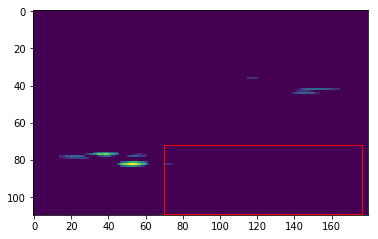

In [88]:
import matplotlib

matplotlib.use('TkAgg')
# fig = plt.figure()

b_box = np.array(df_merged[['x_n', 'y_n', 'x1_n', 'y1_n']].loc[1, :])
fig,ax = plt.subplots(1)
original_frame = np.reshape(df_merged.iloc[1,:19800].to_numpy(),(180, 110))
frame_transposed_flipped = np.flip(np.transpose(original_frame))
details_removed = np.clip(frame_transposed_flipped, a_min=frame_transposed_flipped.max()-15, a_max=None) #to remove not intense pixels
im = plt.imshow(details_removed.astype('int'))

rect = patches.Rectangle((b_box[1], b_box[0]),b_box[3]-b_box[1],b_box[2]-b_box[0],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

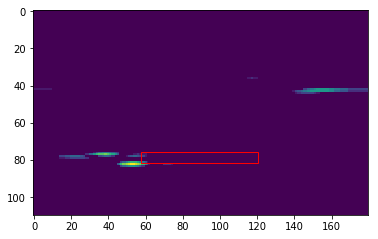

In [93]:
import matplotlib
i = 110
matplotlib.use('TkAgg')
# fig = plt.figure()

b_box = np.array(df_merged[['x_n', 'y_n', 'x1_n', 'y1_n']].loc[i, :])
fig,ax = plt.subplots(1)
original_frame = np.reshape(df_merged.iloc[i,:19800].to_numpy(),(180, 110))
frame_transposed_flipped = np.flip(np.transpose(original_frame))
details_removed = np.clip(frame_transposed_flipped, a_min=frame_transposed_flipped.max()-15, a_max=None) #to remove not intense pixels
im = plt.imshow(details_removed.astype('int'))

rect = patches.Rectangle((b_box[1], b_box[0]),b_box[3]-b_box[1],b_box[2]-b_box[0],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

In [40]:
df = pd.DataFrame(office_data)
df_ma = pd.DataFrame(office_data).rolling(10).mean() 
df_ma.loc[10:,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,...,19755,19756,19757,19758,19759,19760,19761,19762,19763,19764,19765,19766,19767,19768,19769,19770,19771,19772,19773,19774,19775,19776,19777,19778,19779,19780,19781,19782,19783,19784,19785,19786,19787,19788,19789,19790,19791,19792,19793,19794,19795,19796,19797,19798,19799
10,103.838598,99.383164,92.272879,90.593207,86.684946,86.455633,84.402734,87.719677,88.751413,85.660131,94.869825,104.844642,107.806130,102.099662,93.975419,91.532744,87.573562,84.810977,91.556053,88.470784,97.261759,93.031521,81.971440,85.220313,92.831416,87.504281,86.235025,94.513796,103.727309,102.988177,107.822525,108.515143,105.493090,104.328907,90.895742,94.630734,85.321629,87.077133,97.160690,104.811089,103.516848,95.885507,93.163579,88.690905,85.714926,...,94.872908,103.257833,110.919897,105.705939,94.917067,94.237144,94.676653,94.455447,91.882615,86.157542,92.705664,86.605818,93.112016,91.713789,91.655298,86.894833,86.260147,95.291610,94.591049,93.363722,95.080176,82.195584,91.707726,93.736925,89.315202,78.280472,93.959277,92.859690,87.177613,84.705779,80.144676,79.992876,83.273835,91.091486,96.687345,99.769779,97.161668,80.370430,88.883852,78.169008,93.384378,92.353897,89.498591,82.834282,85.000166
11,103.834143,99.376819,92.264925,90.608361,86.714972,86.463567,84.409397,87.740661,88.834782,85.230991,94.465141,104.741380,107.942854,102.875581,95.056240,92.266831,88.986187,85.177853,91.529161,88.340043,97.270115,93.106754,81.837063,85.054442,92.887093,87.554891,86.244478,94.423624,103.703243,102.953586,107.782460,108.513372,105.533545,104.366179,90.960988,94.649915,85.562255,87.600485,97.309259,104.847907,103.525715,95.966141,92.876410,88.254956,86.345677,...,94.665377,103.408779,110.950116,105.578861,94.414753,94.019159,94.400165,94.285560,91.852822,86.133484,92.569666,86.988191,93.184105,91.902811,91.778144,87.099422,86.170023,95.294048,94.634880,93.472498,95.040865,82.203355,91.746367,93.670305,88.875734,78.745829,94.138402,92.991429,87.385588,84.987532,80.411633,79.495627,83.352930,90.990815,96.637364,99.654779,97.023355,80.220328,88.582851,78.910036,93.541783,92.489227,89.415720,82.951682,85.815090
12,103.838978,99.383879,92.244177,90.645285,86.692181,86.438416,84.347151,87.772557,88.796909,85.076936,94.158603,105.021766,108.975370,104.622080,94.632902,92.308469,89.716262,85.474638,91.509830,88.371081,97.264414,93.139286,81.660941,85.190652,92.978714,87.488796,86.113905,94.414931,103.691612,102.921700,107.766265,108.511305,105.550875,104.389456,90.835357,94.678484,85.575378,87.840546,97.375212,104.826976,103.509024,96.049303,93.049343,88.328907,86.157047,...,94.547242,103.402400,110.895834,105.395115,94.310104,94.016585,94.074564,93.965542,91.523838,85.892831,92.503403,87.407227,93.173647,92.005993,91.817538,87.182107,85.908569,95.363456,94.760337,93.453915,94.915326,82.585019,91.759419,93.587088,88.743606,78.649367,94.057028,92.789570,87.539176,85.025934,80.907708,79.277848,83.263578,90.988322,96.628338,99.457416,96.767364,80.218331,88.422191,79.266669,93.692790,92.663767,89.414249,83.926103,87.056119
13,103.839664,99.392922,92.241758,90.622287,86.721744,86.432857,84.355770,87.818024,88.732227,84.831966,93.902661,104.935096,109.206115,105.389472,95.124752,92.484715,90.711859,86.097876,91.535605,88.328377,97.225572,93.216292,81.370567,84.932141,92.930614,87.386753,86.270505,94.455931,103.689926,102.894008,107.753398,108.504593,105.570712,104.431508,90.803538,94.691419,85.830746,87.945888,97.426417,104.817617,103.486196,96.063029,93.048476,88.234741,86.185304,...,94.580462,103.271412,110.825258,105.300780,94.208194,93.986839,93.783066,93.789451,91.555305,85.688313,92.604382,88.095989,93.120837,92.037386,91.947765,87.508102,85.761924,95.438287,94.858670,93.374255,94.807047,81.972777,92.016800,93.643532,88.656705,78.522917,94.069844,92.843213,87.606365,85.153875,80.764626,78.977377,82.965521,90.860672,96.654221,99.388639,96

## Denoising

In [41]:
denoised = np.reshape((df.loc[10:,:]-df_ma.loc[10:,:]).to_numpy(),(df.loc[10:,:].shape[0],180,110))
denoised

array([[[ 1.11505000e-02, -2.73700000e-03,  9.11330000e-02, ...,
         -1.37157983e+00,  4.27962833e-01,  1.79138133e+00],
        [ 1.11505000e-02, -2.73700000e-03,  9.11330000e-02, ...,
         -1.37157983e+00,  4.27962833e-01,  1.79138133e+00],
        [ 1.11505000e-02, -2.73700000e-03,  9.11330000e-02, ...,
         -1.37157983e+00,  4.27962833e-01,  1.79138133e+00],
        ...,
        [ 1.51530000e-02,  2.35333333e-04,  7.73570000e-02, ...,
         -1.43855633e+00,  4.77933500e-01,  2.49253700e+00],
        [ 1.51530000e-02,  2.35333333e-04,  7.73570000e-02, ...,
         -1.43855633e+00,  4.77933500e-01,  2.49253700e+00],
        [ 1.51530000e-02,  2.35333333e-04,  7.73570000e-02, ...,
         -1.43855633e+00,  4.77933500e-01,  2.49253700e+00]],

       [[ 1.19985000e-02, -5.07678333e-02, -5.16751667e-02, ...,
         -1.55701817e+00,  1.54737517e+00,  1.58622467e+00],
        [ 1.19985000e-02, -5.07678333e-02, -5.16751667e-02, ...,
         -1.55701817e+00,  1.54737517e

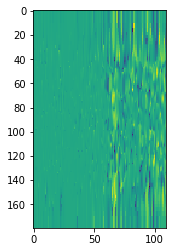

In [42]:
plt.imshow(denoised[100, :, :])

In [43]:
np.savetxt('denoised.txt', (df.loc[10:,:]-df_ma.loc[10:,:]).to_numpy(), delimiter=',')

In [44]:
def rect(r, theta):
    """theta in degrees

    returns tuple; (float, float); (x,y)
    """
    x = r * math.cos(math.radians(theta))
    y = r * math.sin(math.radians(theta))
    return x,y

In [45]:
denoised.shape

(2691, 180, 110)

In [30]:
denoised[1,0,0]

0.028386499999967896

In [31]:
rect(denoised[1,0,0],-90)

(1.738171818197851e-18, -0.028386499999967896)

In [33]:
denoised_flat = (df.loc[10:,:]-df_ma.loc[10:,:]).to_numpy()
denoised_flat.shape

(890, 19800)

In [58]:
cartezian = []
for i in range(denoised[0,:,:].shape[0]):
#     print(i)
    angle = i-90
    for j in range(denoised[0,i,:].shape[0]):
        cartezian.append(rect(denoised[0,i,j], angle))

In [74]:
# denoised_flat[0,:].shape[0]
np.array(cartezian).shape
pd.DataFrame(denoised[0,:,:])

array([[ 0.0119985 , -0.05076783, -0.05167517, ..., -1.55701817,
         1.54737517,  1.58622467],
       [ 0.0119985 , -0.05076783, -0.05167517, ..., -1.55701817,
         1.54737517,  1.58622467],
       [ 0.0119985 , -0.05076783, -0.05167517, ..., -1.55701817,
         1.54737517,  1.58622467],
       ...,
       [ 0.010417  , -0.061219  , -0.0592545 , ..., -1.645208  ,
         1.72593167,  2.110317  ],
       [ 0.010417  , -0.061219  , -0.0592545 , ..., -1.645208  ,
         1.72593167,  2.110317  ],
       [ 0.010417  , -0.061219  , -0.0592545 , ..., -1.645208  ,
         1.72593167,  2.110317  ]])

In [50]:
denoised[0,i,:].shape

(110,)

In [ ]:
# import wradlib

In [2]:
data_folder = "data/"
office_data = np.loadtxt(data_folder + 'demo.txt', delimiter=',')
np.savetxt('data/demo_super_short.txt', office_data[:20,:], delimiter=',')

In [69]:
office_data.shape

(2416, 19800)

# Tune threshold


In [2]:
data_folder = "data/"

# hyperparameters to tune
rolling = 15
min_amplitude = 90

office_data = np.loadtxt(data_folder + 'demo_short.txt', delimiter=',')
print(office_data.shape)
# office_data = return_15_fps(office_data)
print(office_data.shape)
df = pd.DataFrame(office_data)
print("original df shape" + str(df.shape))
df_ma = pd.DataFrame(office_data).rolling(rolling).mean()
print("rolling df shape" + str(df_ma.shape))
# office_data = np.reshape((df.loc[rolling:,:]-df_ma.loc[rolling:,:]).to_numpy(),(df.loc[rolling:,:].shape[0],180,110)) # remove avg images - no background noize kind
office_data = np.reshape(office_data, (office_data.shape[0], 180, 110))

(600, 19800)
(600, 19800)
original df shape(600, 19800)
rolling df shape(600, 19800)


In [4]:
sum(pd.DataFrame(office_data[200,:,:])>110)

5995

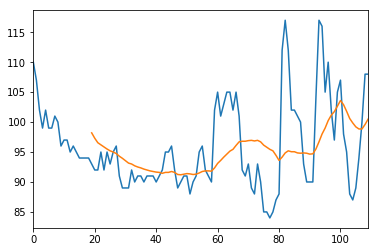

In [66]:
pd.DataFrame(office_data[200,:,:]).max().plot()
pd.DataFrame(office_data[200,:,:]).max().rolling(20).mean().plot()

In [104]:
# pd.DataFrame(office_data[200,:,:]).max()

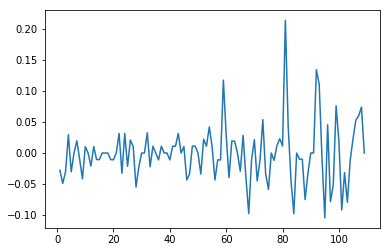

In [63]:
plt.plot(pd.DataFrame(office_data[200,:,:]).max().diff()/pd.DataFrame(office_data[200,:,:]).max())

In [73]:
# count picks by relative difference
a = []
for i in range(office_data.shape[0]):
    b = sum(pd.DataFrame(office_data[i,:,:]).max().diff()/pd.DataFrame(office_data[i,:,:]).max()>0.13)
    a.append(b)


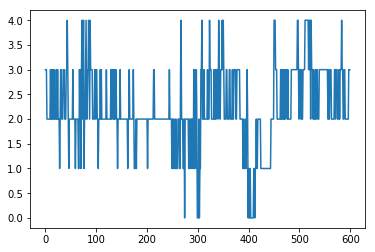

In [74]:
plt.plot(a)

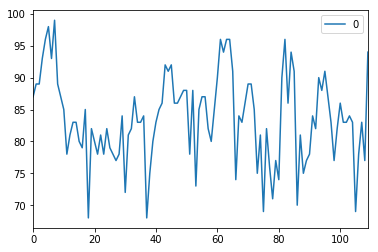

In [9]:
pd.DataFrame(office_data[200,1,:]).plot()

In [53]:
from scipy.signal import argrelextrema
argrelextrema(np.array(pd.DataFrame(office_data[200,:,:]).max().rolling(25).mean()), np.greater)

(array([ 56,  67,  73, 105]),)

In [38]:
a = []
for i in range(office_data.shape[0]):
    b = sum(pd.DataFrame(office_data[i,:,:]).max()>106)
    print(b)
    a.append(b)


14
12
15
13
16
13
13
11
13
13
13
12
14
12
11
13
13
13
13
14
12
15
14
12
12
13
12
15
15
11
13
12
15
13
11
13
13
12
11
11
13
13
12
10
10
13
13
13
12
11
11
14
15
15
15
13
14
13
13
13
12
11
15
12
15
14
15
14
15
13
13
14
14
14
14
14
14
14
12
14
14
14
12
14
13
14
14
12
14
15
16
14
13
12
12
13
13
15
16
15
15
17
14
11
14
13
15
15
15
16
17
12
13
11
13
13
13
13
18
15
14
11
13
15
12
15
13
11
11
13
12
13
14
14
14
12
11
11
11
14
15
13
12
13
12
11
12
13
11
11
11
12
11
11
12
12
13
12
12
13
13
13
11
11
11
11
11
11
11
11
11
11
11
11
12
12
11
11
11
11
12
13
12
11
11
11
13
13
11
12
13
11
12
11
12
11
13
11
11
13
11
12
13
11
14
12
13
11
13
12
11
15
12
13
15
13
14
13
13
14
13
15
14
14
16
15
16
14
13
16
16
14
16
15
16
15
15
14
14
14
12
12
14
14
14
13
13
13
13
12
13
13
11
13
12
14
13
12
17
15
14
14
13
16
11
13
12
13
13
15
13
13
12
12
11
12
12
13
12
15
13
13
14
13
11
16
17
19
18
16
16
18
16
17
15
17
19
15
15
14
13
10
13
12
15
17
14
13
16
13
16
13
17
18
19
15
12
13
16
13
11
14
16
16
17
15
18
18
18
17
16
17
16
1

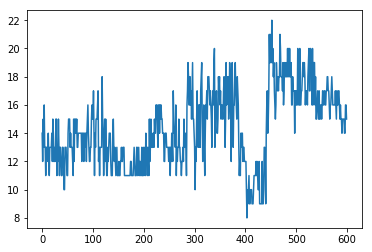

In [39]:
plt.plot(a)

In [42]:
np.percentile(office_data[:,:,:].flatten(), 99.8)

113.0

In [8]:
from scipy.signal import find_peaks
find_peaks(office_data[200,1,:], height=0)

(array([  5,   7,  13,  17,  19,  22,  24,  29,  33,  36,  43,  45,  49,
         52,  55,  61,  63,  67,  70,  74,  76,  79,  82,  84,  87,  91,
         93,  95, 100, 103, 107]),
 {'peak_heights': array([98., 99., 83., 85., 82., 81., 82., 84., 87., 84., 92., 92., 88.,
         88., 87., 96., 96., 84., 89., 81., 82., 77., 96., 94., 81., 84.,
         90., 91., 86., 84., 83.])})

## OpenCV SimpleBlobDetector

In [6]:
import scipy.misc
rgb = scipy.misc.toimage(office_data[200,:10,:10])
rgb

/Users/elizavetalebedeva/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


In [7]:
import cv2
img = np.zeros([10,10,3])
img[:,:,0] = office_data[200,:10,:10]*1
img[:,:,1] = office_data[200,:10,:10]*1
img[:,:,2] = office_data[200,:10,:10]*0

r,g,b = cv2.split(img)
img_bgr = cv2.merge([b,g,r])

In [8]:
img_bgr

array([[[ 0., 87., 87.],
        [ 0., 89., 89.],
        [ 0., 89., 89.],
        [ 0., 93., 93.],
        [ 0., 96., 96.],
        [ 0., 98., 98.],
        [ 0., 93., 93.],
        [ 0., 99., 99.],
        [ 0., 89., 89.],
        [ 0., 87., 87.]],

       [[ 0., 87., 87.],
        [ 0., 89., 89.],
        [ 0., 89., 89.],
        [ 0., 93., 93.],
        [ 0., 96., 96.],
        [ 0., 98., 98.],
        [ 0., 93., 93.],
        [ 0., 99., 99.],
        [ 0., 89., 89.],
        [ 0., 87., 87.]],

       [[ 0., 87., 87.],
        [ 0., 89., 89.],
        [ 0., 89., 89.],
        [ 0., 93., 93.],
        [ 0., 96., 96.],
        [ 0., 98., 98.],
        [ 0., 93., 93.],
        [ 0., 99., 99.],
        [ 0., 89., 89.],
        [ 0., 87., 87.]],

       [[ 0., 87., 87.],
        [ 0., 89., 89.],
        [ 0., 89., 89.],
        [ 0., 93., 93.],
        [ 0., 96., 96.],
        [ 0., 98., 98.],
        [ 0., 93., 93.],
        [ 0., 99., 99.],
        [ 0., 89., 89.],
        [ 0., 87., 

In [ ]:
import cv2
cv2.imwrite('color_img.jpg', img_bgr)
im = cv2.imread('color_img.jpg', cv2.IMREAD_GRAYSCALE)
 
# Set up the detector with default parameters.
is_v2 = cv2.__version__.startswith("2.")
if is_v2:
    detector = cv2.SimpleBlobDetector()
else:
    detector = cv2.SimpleBlobDetector_create() 
# Detect blobs.
keypoints = detector.detect(im)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)